### Распределение эмбеддингов текстов. 
Энкодер: all-mpnet-base-v2

In [1]:
SEED = 42
ENCODER = "sentence-transformers/all-mpnet-base-v2"
MAX_HUMAN_SAMPLES = 10000

MAX_VIS_SAMPLES = 2000

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_recall_curve
from sklearn.decomposition import PCA
from scipy.special import softmax
from random import sample
from scipy.stats import skew, kurtosis
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [3]:
# https://huggingface.co/sentence-transformers/all-mpnet-base-v2

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    
def get_embeddings(tokenizer, model, df, batch_size=16, device=None):
    if device is None:
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
    
    model.to(device)
    model.eval()
    all_embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df[i:i + batch_size].tolist()
        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )

        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        with torch.no_grad():
            model_output = model(**encoded_input)
            embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

        all_embeddings.append(embeddings.cpu())

        if device.type == "mps":
            torch.mps.empty_cache()

    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings


In [4]:
sns.set(style="whitegrid")

def subsample(X_h, X_ai, max_samples):
    idx_h = list(range(len(X_h)))
    idx_ai = list(range(len(X_ai)))

    if len(idx_h) > max_samples // 2:
        idx_h = sample(idx_h, max_samples // 2)
    if len(idx_ai) > max_samples // 2:
        idx_ai = sample(idx_ai, max_samples // 2)

    X = np.vstack([X_h[idx_h], X_ai[idx_ai]])
    y = np.concatenate([np.zeros(len(idx_h)), np.ones(len(idx_ai))])

    return X, y


def plot_mahalanobis_distributions(scores_human, scores_ai, name):
    plt.figure(figsize=(8, 5))

    all_scores = np.concatenate([scores_human, scores_ai])
    bins = np.histogram_bin_edges(all_scores, bins="auto")

    plt.hist(scores_human, bins=bins, density=True, alpha=0.6, label="Человек")
    plt.hist(scores_ai, bins=bins, density=True, alpha=0.6, label="ИИ")

    plt.title(f"Распределение расстояния Махаланобиса (набор '{name}')")
    plt.xlabel("Квадрат расстояния Махаланобиса")
    plt.ylabel("Плотность")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_roc_curve(y_true, scores, roc_auc, name):
    fpr, tpr, _ = roc_curve(y_true, scores)
    
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate TPR")
    plt.title(f"ROC-кривая ('{name}')")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()


def plot_pca_projection(X_human, X_ai, name):
    X, y = subsample(X_human, X_ai, MAX_VIS_SAMPLES)
    X_2d = PCA(n_components=2, random_state=SEED).fit_transform(X)

    plt.figure(figsize=(8, 5))
    scatter = sns.scatterplot(
        x=X_2d[:, 0], y=X_2d[:, 1],
        hue=y, palette={0: "blue", 1: "orange"},
        alpha=0.5, s=35
    )
    plt.title(f"Проекция PCA (dataset '{name}')")

    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles=handles, labels=["Человек", "ИИ"])
    plt.tight_layout()
    
    plt.show()


def print_header(title, char="="):
    print(f"\n{char * 100}")
    print(title)
    print(f"{char * 100}")


def print_subheader(title):
    print(f"\n--- {title} ---")


def print_kv(key, value, width=35):
    print(f"{key:<{width}}: {value}")


def covariance_spectrum(cov, top_k=100):
    C = cov.covariance_
    
    eigvals = np.linalg.eigvalsh(C)
    eigvals = eigvals[::-1]
    
    explained = eigvals / eigvals.sum()
    cumulative = np.cumsum(explained)

    fig, ax = plt.subplots(2, 1, figsize=(8, 8))

    ax[0].bar(range(1, top_k + 1), explained[:top_k])
    ax[0].set_title("Объясненная дисперсия (первые компоненты)")
    ax[0].set_xlabel("Номер компоненты")
    ax[0].set_ylabel("Доля объясненной дисперсии")

    ax[1].plot(range(1, top_k + 1), cumulative[:top_k], marker="o")
    ax[1].axhline(0.9, color="r", linestyle="--", label="90%")
    ax[1].axhline(0.95, color="g", linestyle="--", label="95%")
    ax[1].set_title("Накопленная объясненная дисперсия")
    ax[1].set_xlabel("Число компонент")
    ax[1].set_ylabel("Накопленная доля дисперсии")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    

def print_mahalanobis_stats(scores, label, width=50, precision=4):
    stats = {
        "Среднее": scores.mean(),
        "Стд. отклонение": scores.std(),
        "Асимметрия": skew(scores),
        "Эксцесс": kurtosis(scores),
        "95% квантиль": np.quantile(scores, 0.95),
        "99% квантиль": np.quantile(scores, 0.99),
    }
    
    print(f"Статистики расстояния Махаланобиса ({label})")
    print("=" * width)
    for k, v in stats.items():
        print(f"{k:<18s} | {v:>{width-22}.{precision}f}")
    print("=" * width)
    print("")


def print_norm_stats(X, precision=4):
    norms = np.linalg.norm(X, axis=1)
    
    stats = {
        "Среднее значение нормы": norms.mean(),
        "Стандартное отклонение": norms.std(),
    }
        
    print("Статистики норм векторов")
    print("=" * 32)
    for k, v in stats.items():
        print(f"{k:<24s}: {v:.{precision}f}")
    print("=" * 32)
    print("")

In [5]:
human_df = (
    pd.read_csv("../datasets/human_essays.csv", encoding="utf-8")
    .assign(label=0)[["text", "label"]]
    .reset_index(drop=True)
)

if MAX_HUMAN_SAMPLES is not None:
    human_df = human_df[:MAX_HUMAN_SAMPLES]

print(f"Живых текстов: {len(human_df)}")

Живых текстов: 10000


In [6]:
filenames = {
    "Mistral 7B 1": "../datasets/mistral_essays_1.csv",
    "Mistral 7B 2": "../datasets/mistral_essays_2.csv",
    "Mistral 7B 3": "../datasets/mistral_essays_3.csv",
    "Mistral 7B 4": "../datasets/mistral_essays_4.csv",
    "Mistral 7B 5": "../datasets/mistral_essays_5.csv",
    "Llama 3 13B 1": "../datasets/llama_essays_1.csv",
    "Llama 3 13B 2": "../datasets/llama_essays_2.csv",
    "Llama 3 13B 3": "../datasets/llama_essays_3.csv",
    "Llama 3 13B 4": "../datasets/llama_essays_4.csv",
    "Llama 3 13B 5": "../datasets/llama_essays_5.csv",
    "DeepSeek V3.2 1": "../datasets/deepseek_essays_1.csv",
    "DeepSeek V3.2 2": "../datasets/deepseek_essays_2.csv",
    "DeepSeek V3.2 3": "../datasets/deepseek_essays_3.csv",
    "DeepSeek V3.2 4": "../datasets/deepseek_essays_4.csv",
    "DeepSeek V3.2 5": "../datasets/deepseek_essays_5.csv",
    "ChatGPT 1": "../datasets/chatgpt_essays_1.csv",
    "ChatGPT 2": "../datasets/chatgpt_essays_2.csv",
    "ChatGPT 3": "../datasets/chatgpt_essays_3.csv",
    "ChatGPT 4": "../datasets/chatgpt_essays_4.csv",
    "ChatGPT 5": "../datasets/chatgpt_essays_5.csv",
}

ai_datasets = {}
for name, fn in filenames.items():
    df = pd.read_csv(fn, encoding="utf-8").assign(label=1)[["text", "label"]].reset_index(drop=True)
    ai_datasets[name] = df
    print(f"Загружен датасет '{name}'. {len(df)} записей")

Загружен датасет 'Mistral 7B 1'. 1500 записей
Загружен датасет 'Mistral 7B 2'. 1500 записей
Загружен датасет 'Mistral 7B 3'. 1500 записей
Загружен датасет 'Mistral 7B 4'. 1500 записей
Загружен датасет 'Mistral 7B 5'. 1500 записей
Загружен датасет 'Llama 3 13B 1'. 999 записей
Загружен датасет 'Llama 3 13B 2'. 1000 записей
Загружен датасет 'Llama 3 13B 3'. 994 записей
Загружен датасет 'Llama 3 13B 4'. 997 записей
Загружен датасет 'Llama 3 13B 5'. 999 записей
Загружен датасет 'DeepSeek V3.2 1'. 3000 записей
Загружен датасет 'DeepSeek V3.2 2'. 3000 записей
Загружен датасет 'DeepSeek V3.2 3'. 2999 записей
Загружен датасет 'DeepSeek V3.2 4'. 3000 записей
Загружен датасет 'DeepSeek V3.2 5'. 2500 записей
Загружен датасет 'ChatGPT 1'. 2000 записей
Загружен датасет 'ChatGPT 2'. 2000 записей
Загружен датасет 'ChatGPT 3'. 2000 записей
Загружен датасет 'ChatGPT 4'. 2000 записей
Загружен датасет 'ChatGPT 5'. 2000 записей



ENCODER: sentence-transformers/all-mpnet-base-v2


100%|█████████████████████████████████████████| 625/625 [04:25<00:00,  2.35it/s]


Статистики норм векторов
Среднее значение нормы  : 2.3408
Стандартное отклонение  : 0.1279

Эмбеддинги живых текстов (train)   : 7000
Эмбеддинги живых текстов (test)    : 3000


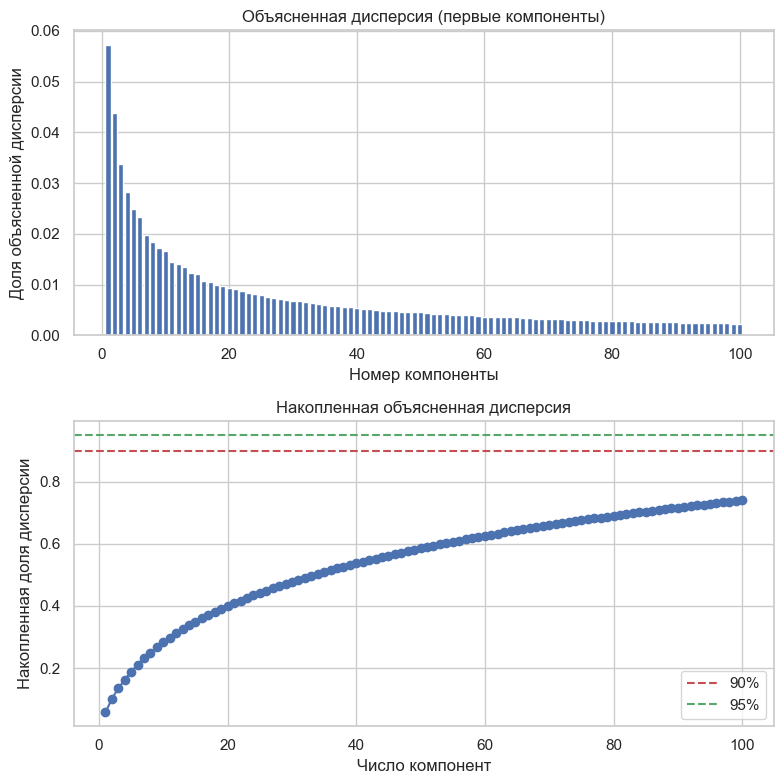


Набор: Mistral 7B 1
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.36it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     751.7370
Стд. отклонение    |                     312.3035
Асимметрия         |                       1.7727
Эксцесс            |                       5.4475
95% квантиль       |                    1325.9656
99% квантиль       |                    1802.1245

Статистики расстояния Махаланобиса (ии)
Среднее            |                     796.7214
Стд. отклонение    |                     311.3778
Асимметрия         |                       2.0982
Эксцесс            |                       9.8431
95% квантиль       |                    1369.2082
99% квантиль       |                    1801.9347

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.5564


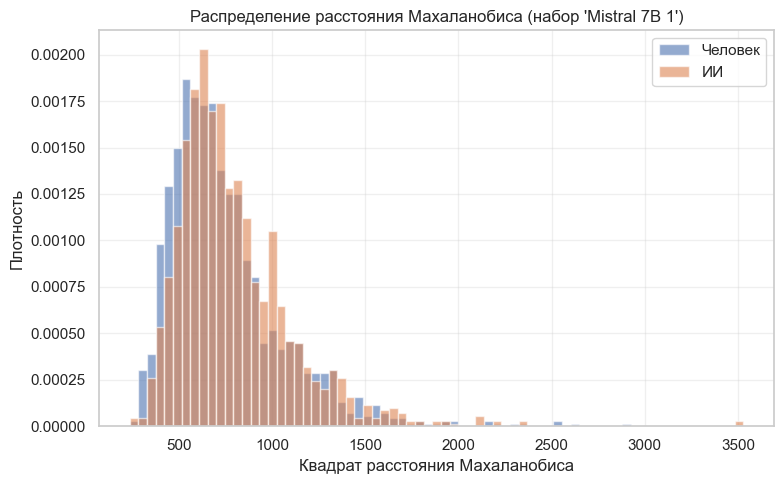

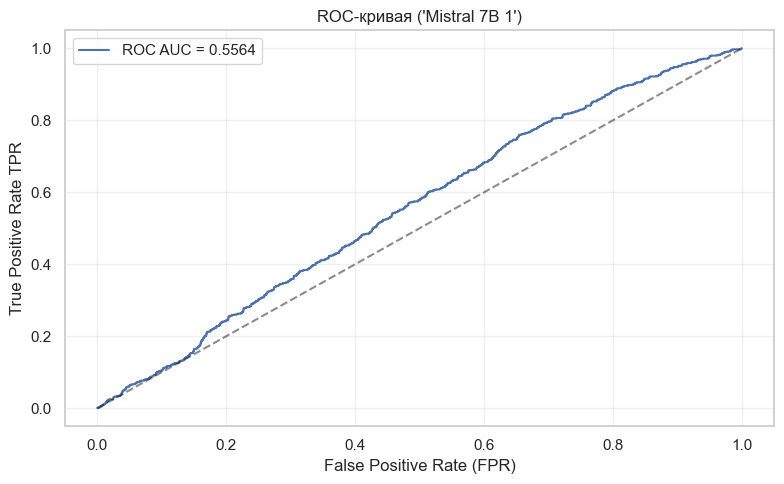

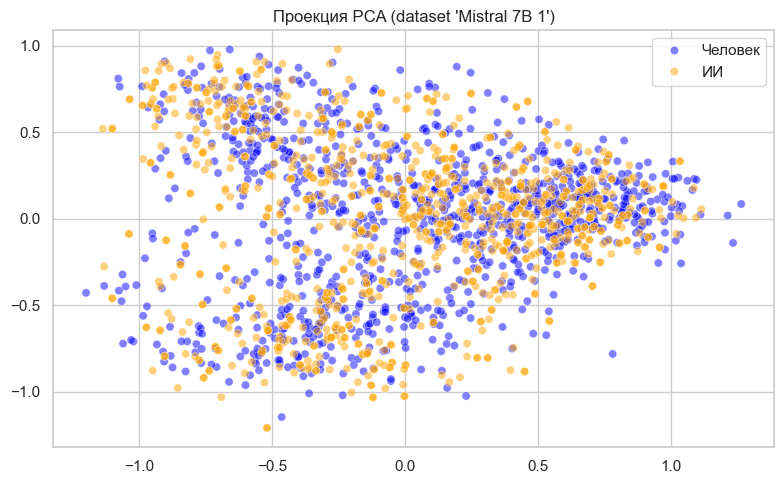


Набор: Mistral 7B 2
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:40<00:00,  2.33it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     751.7370
Стд. отклонение    |                     312.3035
Асимметрия         |                       1.7727
Эксцесс            |                       5.4475
95% квантиль       |                    1325.9656
99% квантиль       |                    1802.1245

Статистики расстояния Махаланобиса (ии)
Среднее            |                     817.5515
Стд. отклонение    |                     317.6495
Асимметрия         |                       3.3578
Эксцесс            |                      31.3426
95% квантиль       |                    1354.4247
99% квантиль       |                    1784.1248

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.5853


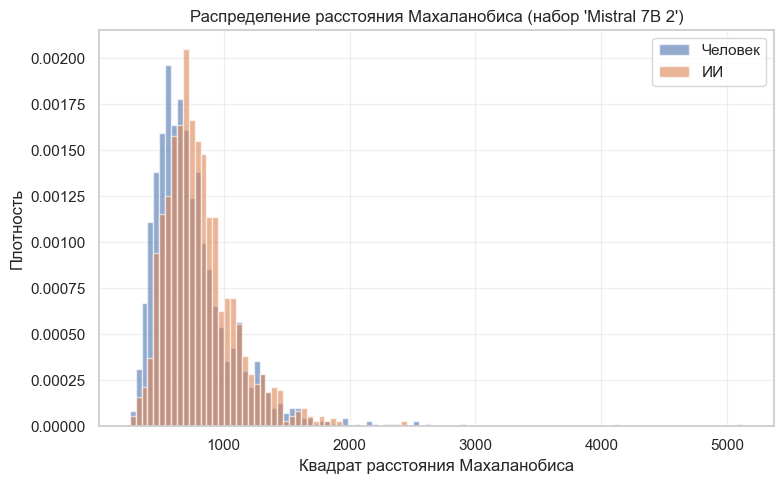

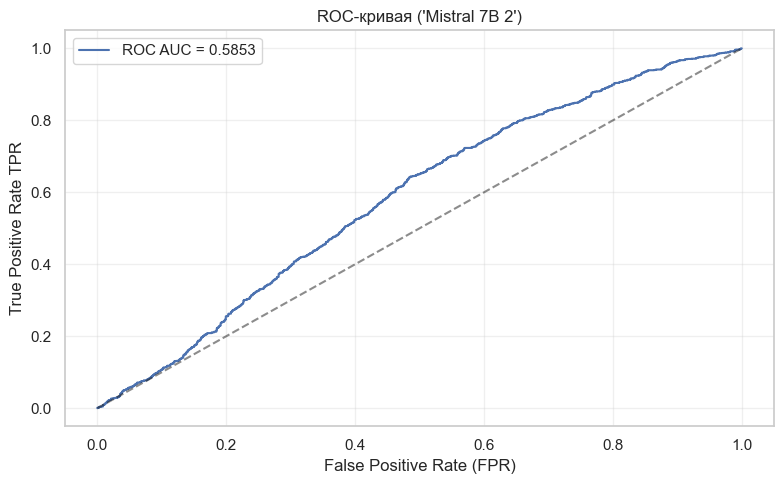

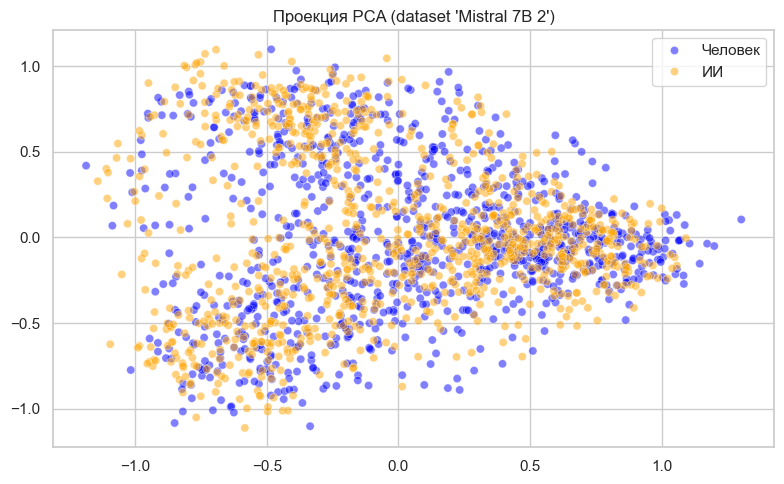


Набор: Mistral 7B 3
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.38it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     751.7370
Стд. отклонение    |                     312.3035
Асимметрия         |                       1.7727
Эксцесс            |                       5.4475
95% квантиль       |                    1325.9656
99% квантиль       |                    1802.1245

Статистики расстояния Махаланобиса (ии)
Среднее            |                     801.0271
Стд. отклонение    |                     323.2526
Асимметрия         |                       2.6742
Эксцесс            |                      17.8926
95% квантиль       |                    1386.2228
99% квантиль       |                    1762.6157

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.5592


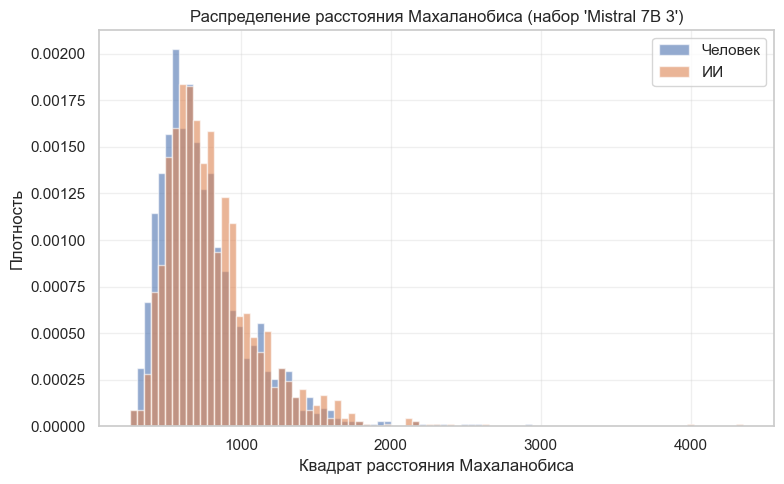

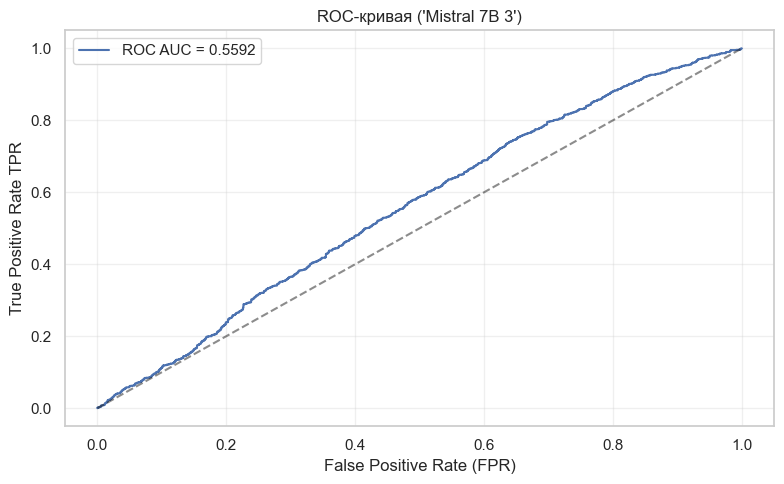

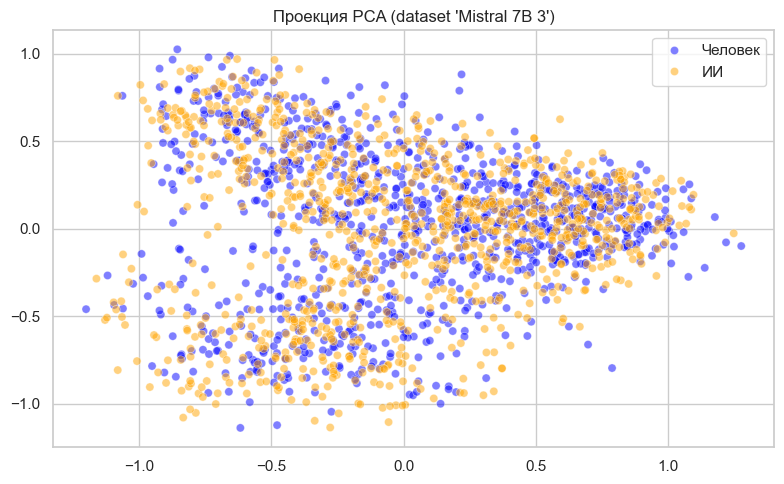


Набор: Mistral 7B 4
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:39<00:00,  2.36it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     751.7370
Стд. отклонение    |                     312.3035
Асимметрия         |                       1.7727
Эксцесс            |                       5.4475
95% квантиль       |                    1325.9656
99% квантиль       |                    1802.1245

Статистики расстояния Махаланобиса (ии)
Среднее            |                     798.0693
Стд. отклонение    |                     328.5228
Асимметрия         |                       3.5365
Эксцесс            |                      30.7190
95% квантиль       |                    1386.1782
99% квантиль       |                    1881.9064

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.5574


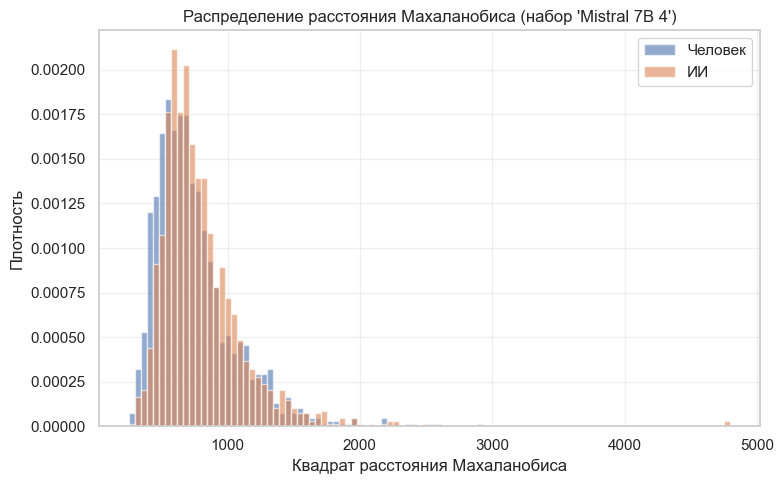

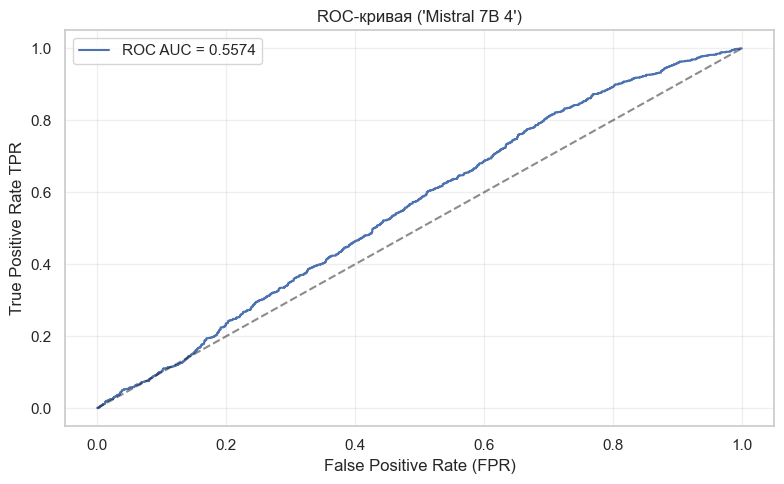

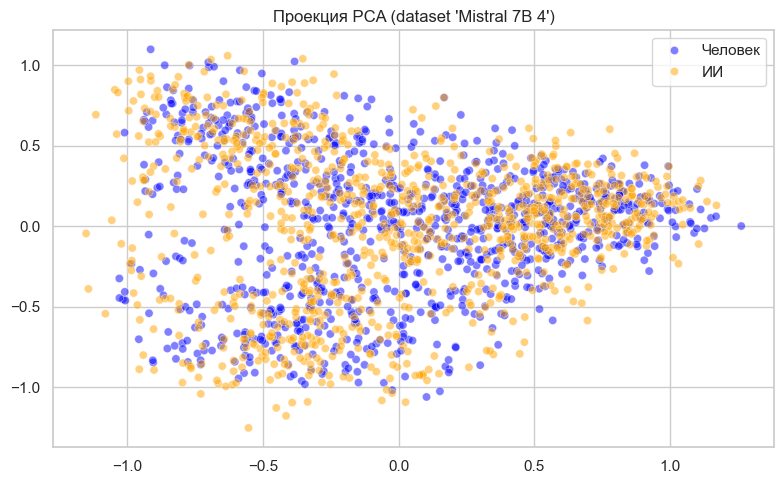


Набор: Mistral 7B 5
----------------------------------------


100%|███████████████████████████████████████████| 94/94 [00:40<00:00,  2.33it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     751.7370
Стд. отклонение    |                     312.3035
Асимметрия         |                       1.7727
Эксцесс            |                       5.4475
95% квантиль       |                    1325.9656
99% квантиль       |                    1802.1245

Статистики расстояния Махаланобиса (ии)
Среднее            |                     804.8666
Стд. отклонение    |                     287.7755
Асимметрия         |                       2.3222
Эксцесс            |                      11.1149
95% квантиль       |                    1283.7334
99% квантиль       |                    1817.6847

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1500
ROC-AUC                            : 0.5817


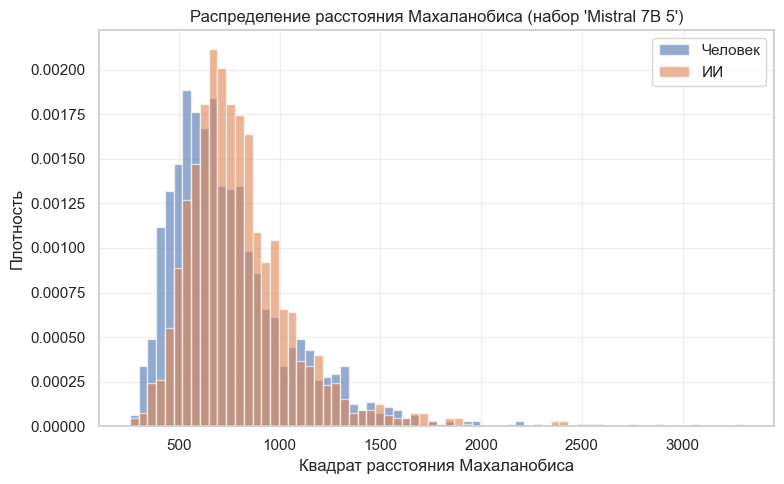

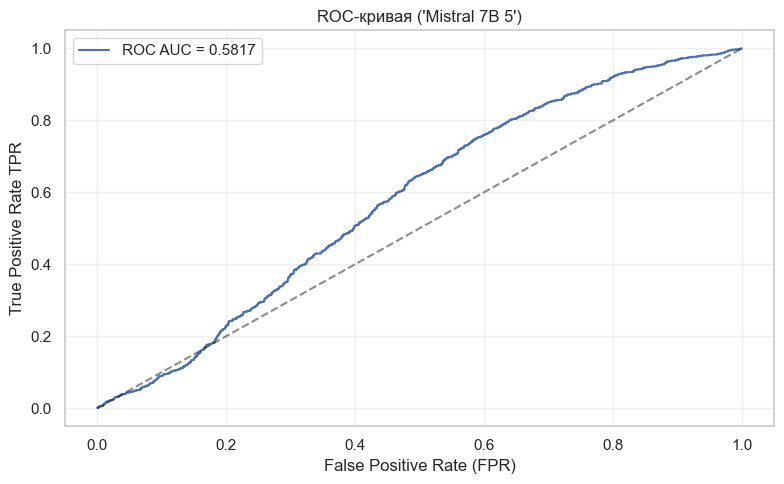

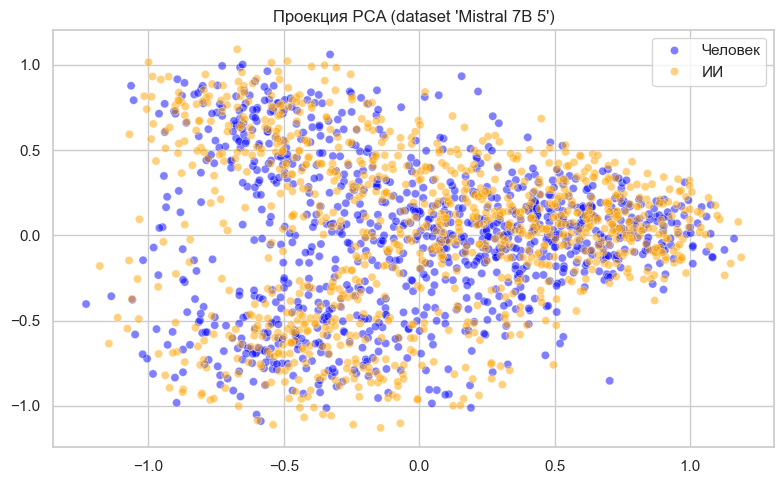


Набор: Llama 3 13B 1
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:26<00:00,  2.42it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     746.6333
Стд. отклонение    |                     301.2616
Асимметрия         |                       1.6095
Эксцесс            |                       4.3456
95% квантиль       |                    1319.6313
99% квантиль       |                    1720.4134

Статистики расстояния Махаланобиса (ии)
Среднее            |                     810.3234
Стд. отклонение    |                     326.8093
Асимметрия         |                       4.6459
Эксцесс            |                      59.0809
95% квантиль       |                    1380.7746
99% квантиль       |                    1706.2372

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 999
ROC-AUC                            : 0.5782


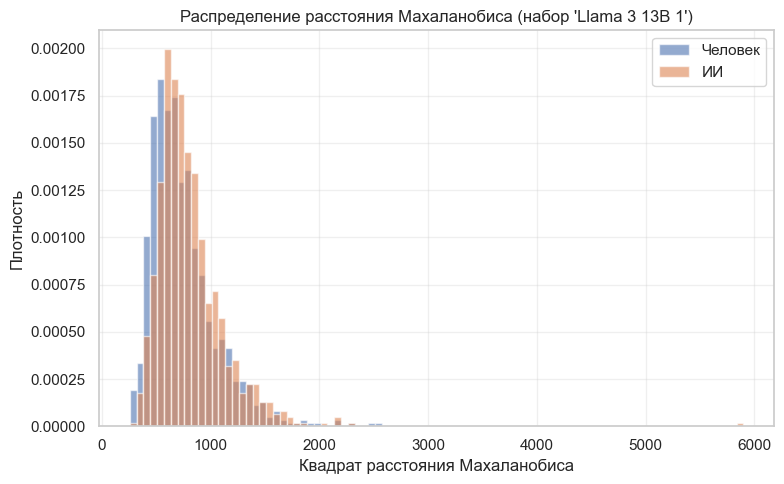

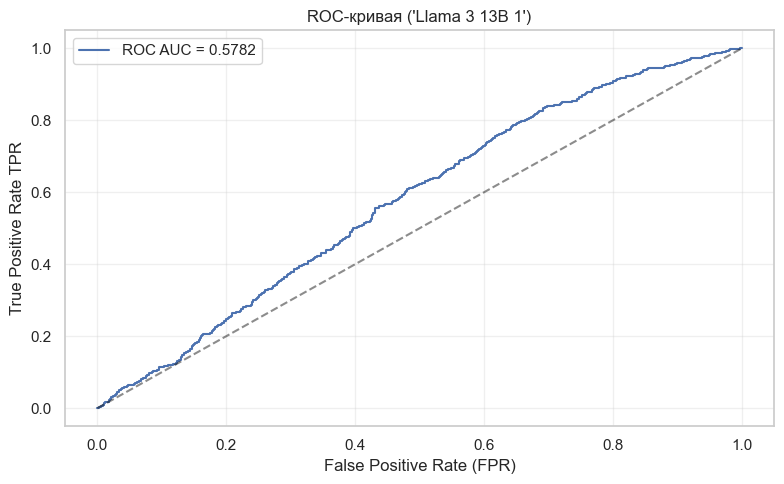

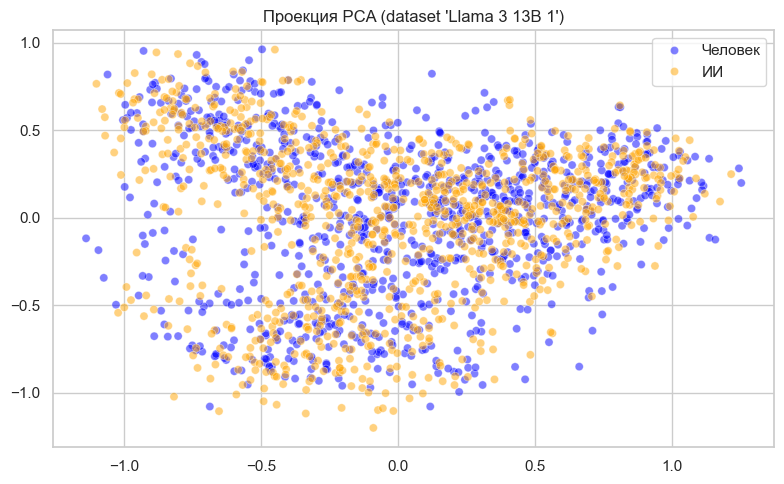


Набор: Llama 3 13B 2
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:26<00:00,  2.37it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     746.5523
Стд. отклонение    |                     301.1219
Асимметрия         |                       1.6109
Эксцесс            |                       4.3537
95% квантиль       |                    1319.4298
99% квантиль       |                    1719.9849

Статистики расстояния Махаланобиса (ии)
Среднее            |                     835.3879
Стд. отклонение    |                     313.6343
Асимметрия         |                       2.7617
Эксцесс            |                      17.5757
95% квантиль       |                    1341.5026
99% квантиль       |                    1866.6469

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 1000
ROC-AUC                            : 0.6084


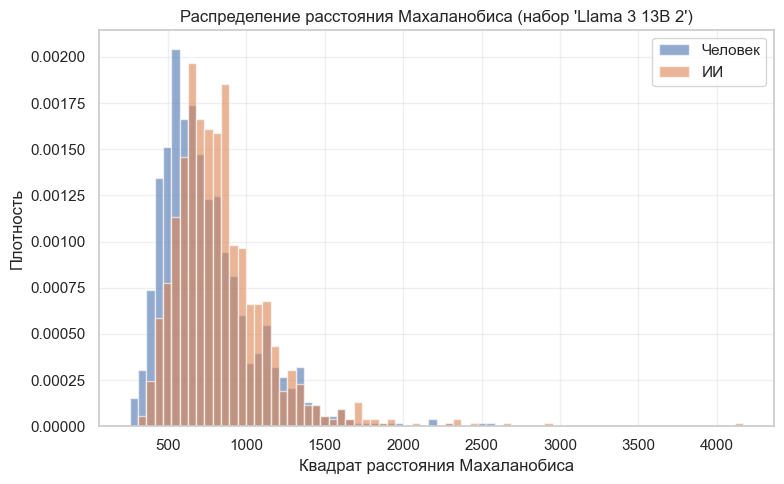

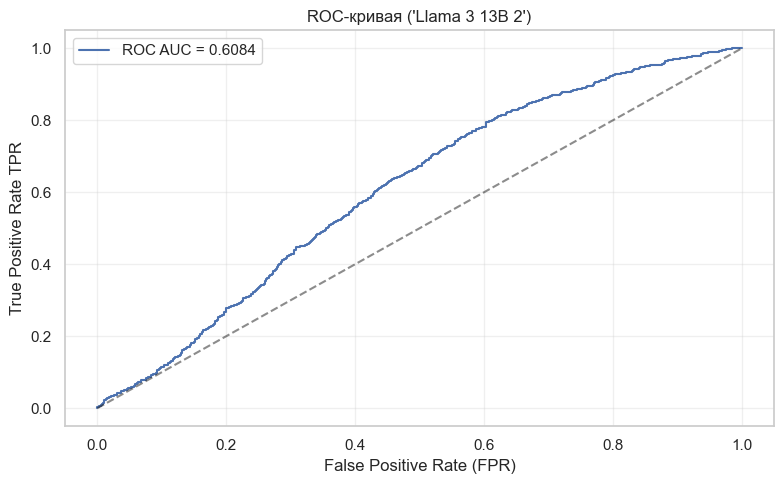

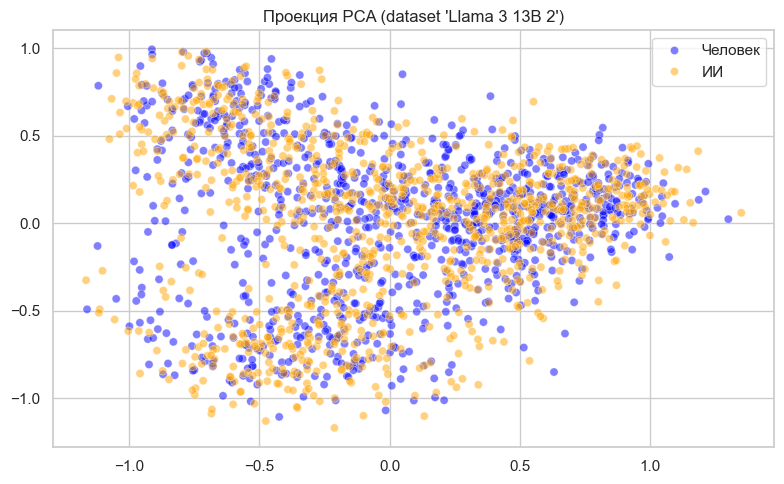


Набор: Llama 3 13B 3
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:26<00:00,  2.40it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     747.0334
Стд. отклонение    |                     301.8232
Асимметрия         |                       1.6054
Эксцесс            |                       4.3186
95% квантиль       |                    1320.6386
99% квантиль       |                    1722.5559

Статистики расстояния Махаланобиса (ии)
Среднее            |                     812.6935
Стд. отклонение    |                     299.6360
Асимметрия         |                       1.5250
Эксцесс            |                       3.5737
95% квантиль       |                    1403.8165
99% квантиль       |                    1820.8910

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 994
ROC-AUC                            : 0.5810


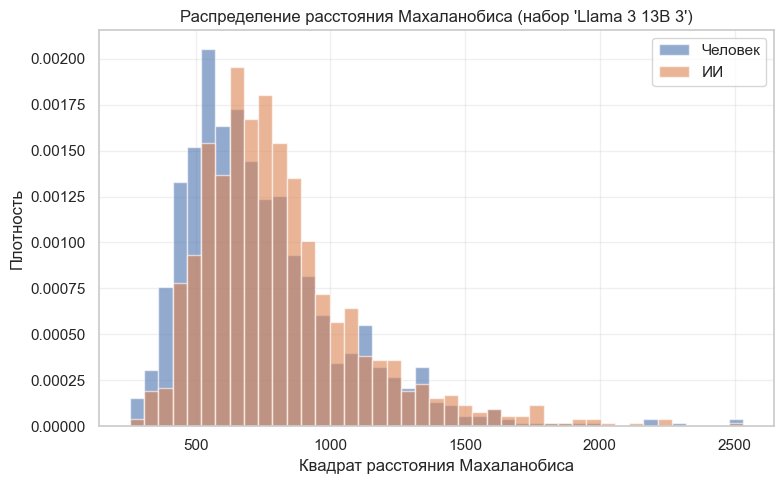

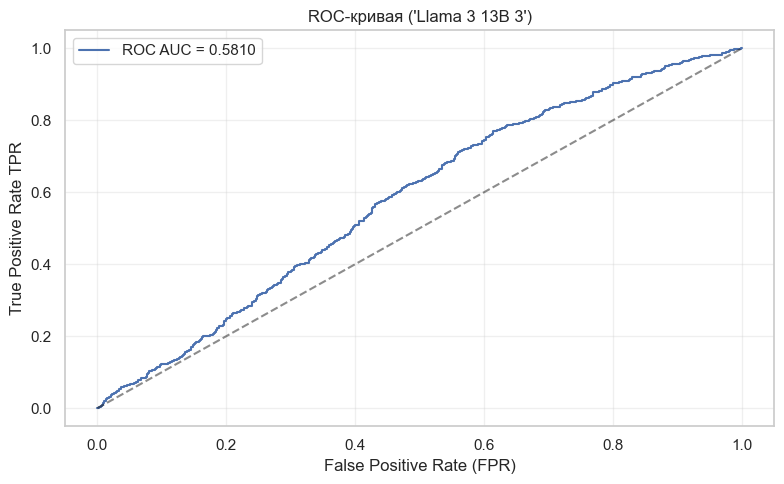

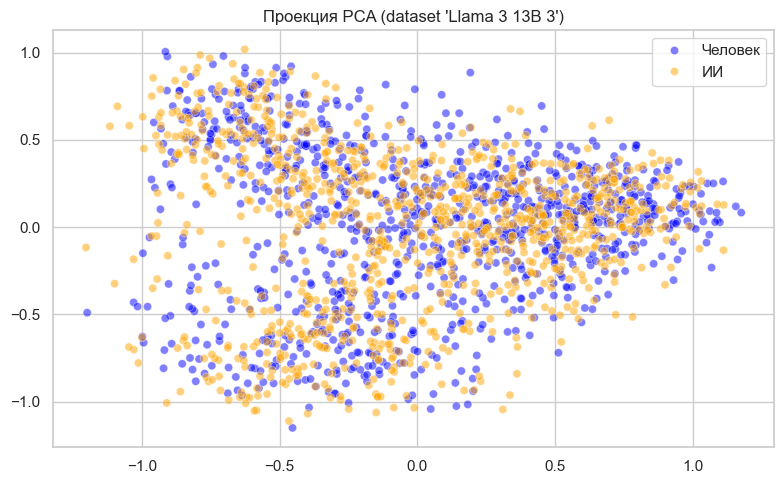


Набор: Llama 3 13B 4
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:26<00:00,  2.39it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     747.0841
Стд. отклонение    |                     301.3927
Асимметрия         |                       1.6070
Эксцесс            |                       4.3373
95% квантиль       |                    1320.0342
99% квантиль       |                    1721.2704

Статистики расстояния Махаланобиса (ии)
Среднее            |                     794.3533
Стд. отклонение    |                     294.1997
Асимметрия         |                       2.0581
Эксцесс            |                       8.4685
95% квантиль       |                    1312.3264
99% квантиль       |                    1812.1511

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 997
ROC-AUC                            : 0.5636


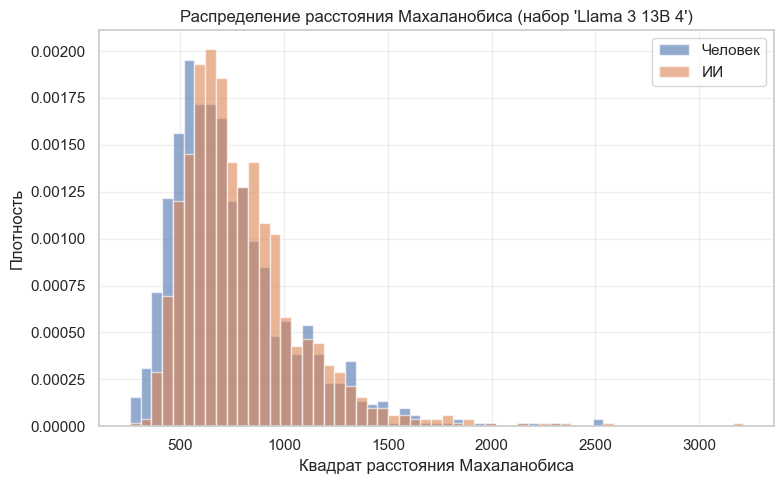

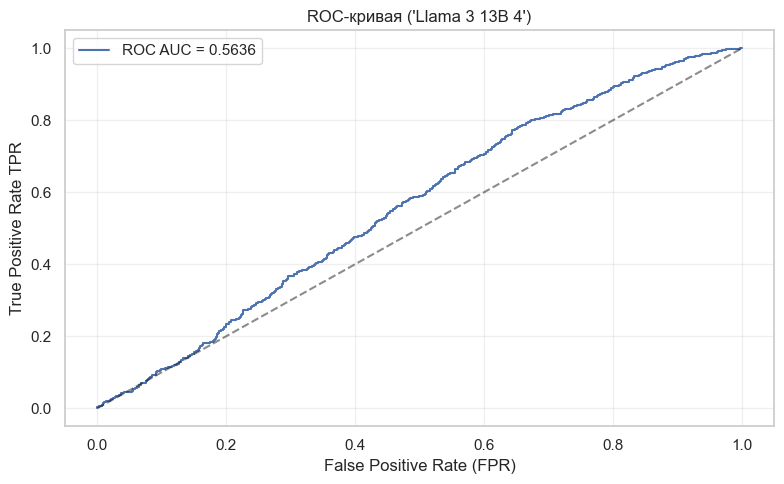

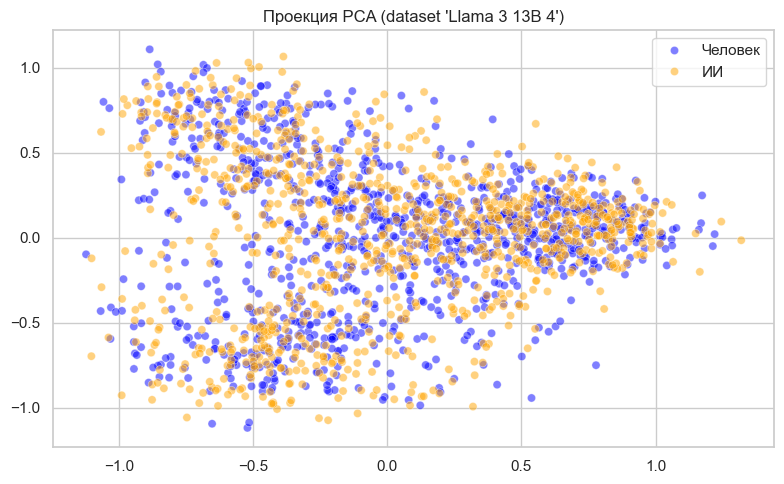


Набор: Llama 3 13B 5
----------------------------------------


100%|███████████████████████████████████████████| 63/63 [00:26<00:00,  2.39it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     746.6333
Стд. отклонение    |                     301.2616
Асимметрия         |                       1.6095
Эксцесс            |                       4.3456
95% квантиль       |                    1319.6313
99% квантиль       |                    1720.4134

Статистики расстояния Махаланобиса (ии)
Среднее            |                     785.4262
Стд. отклонение    |                     282.1465
Асимметрия         |                       1.9505
Эксцесс            |                       7.3823
95% квантиль       |                    1329.1662
99% квантиль       |                    1705.1689

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 999
ROC-AUC                            : 0.5598


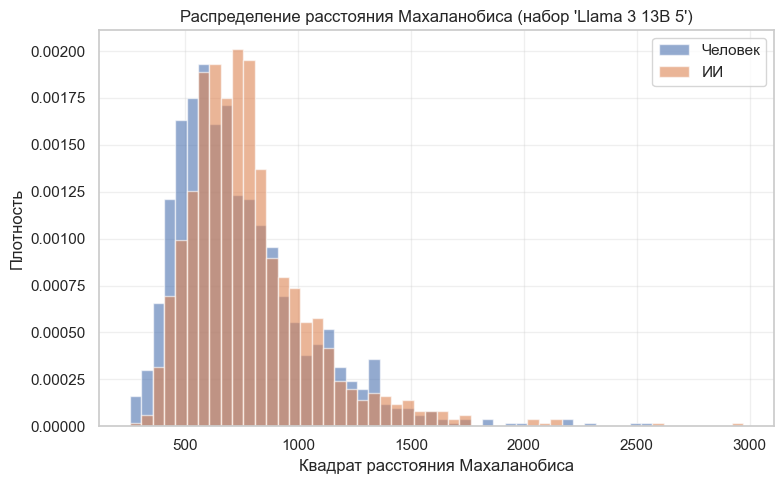

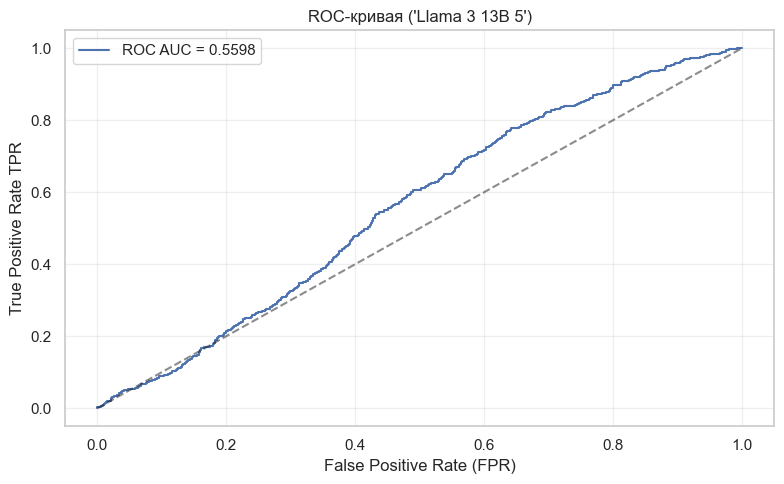

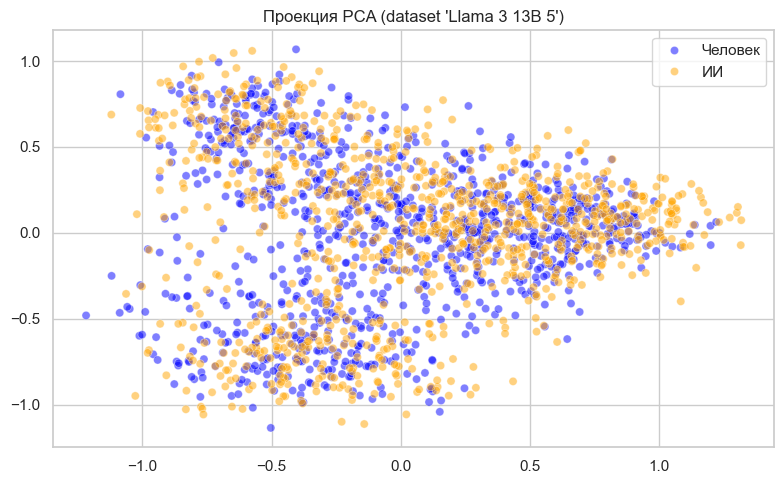


Набор: DeepSeek V3.2 1
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     749.7953
Стд. отклонение    |                     311.2693
Асимметрия         |                       1.8275
Эксцесс            |                       5.7750
95% квантиль       |                    1331.3513
99% квантиль       |                    1814.7336

Статистики расстояния Махаланобиса (ии)
Среднее            |                     734.3040
Стд. отклонение    |                     256.9216
Асимметрия         |                       1.9365
Эксцесс            |                       6.7549
95% квантиль       |                    1194.8360
99% квантиль       |                    1679.3875

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.5059


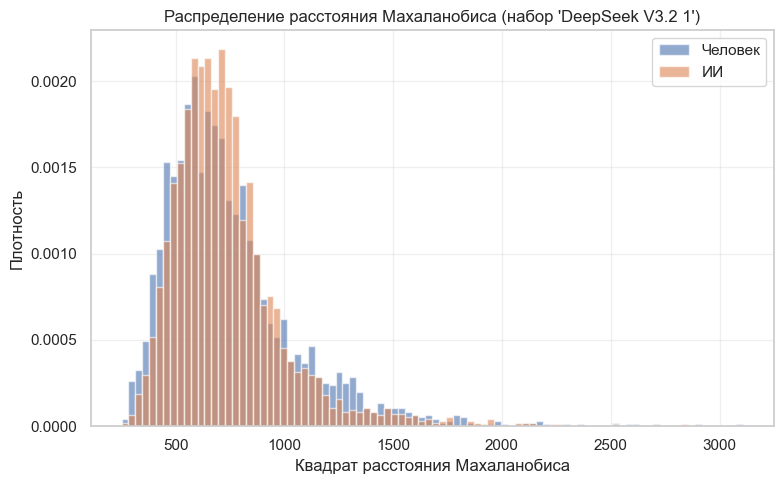

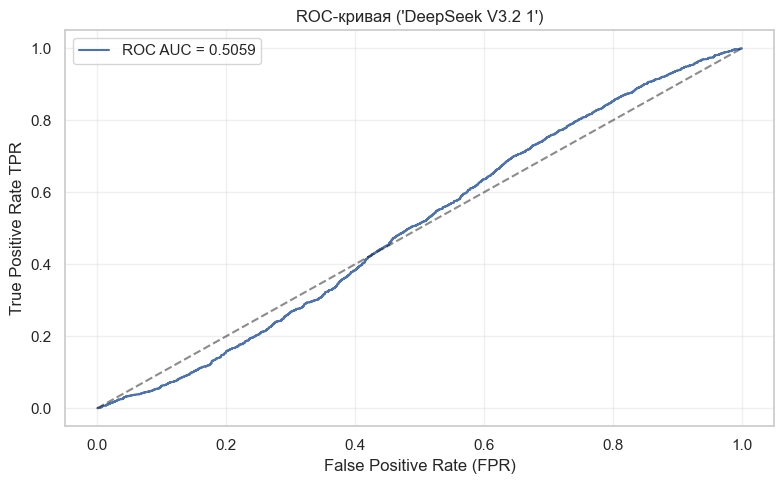

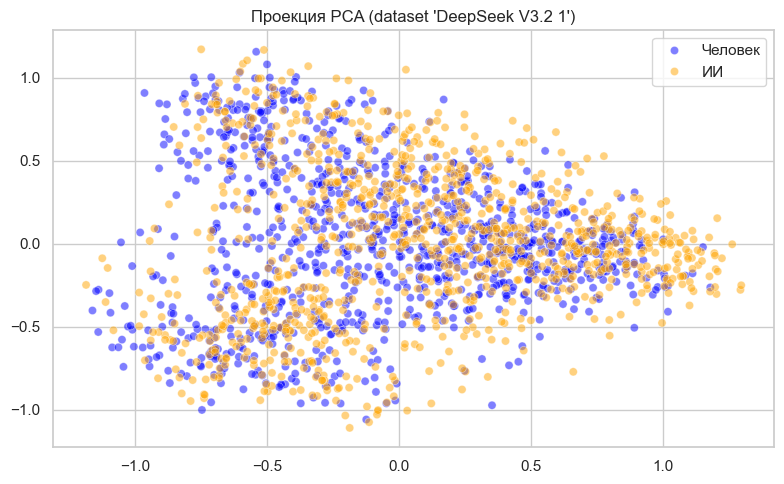


Набор: DeepSeek V3.2 2
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:19<00:00,  2.35it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     749.7953
Стд. отклонение    |                     311.2693
Асимметрия         |                       1.8275
Эксцесс            |                       5.7750
95% квантиль       |                    1331.3513
99% квантиль       |                    1814.7336

Статистики расстояния Махаланобиса (ии)
Среднее            |                     742.1566
Стд. отклонение    |                     256.0276
Асимметрия         |                       1.7515
Эксцесс            |                       5.2528
95% квантиль       |                    1231.4410
99% квантиль       |                    1705.3293

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.5147


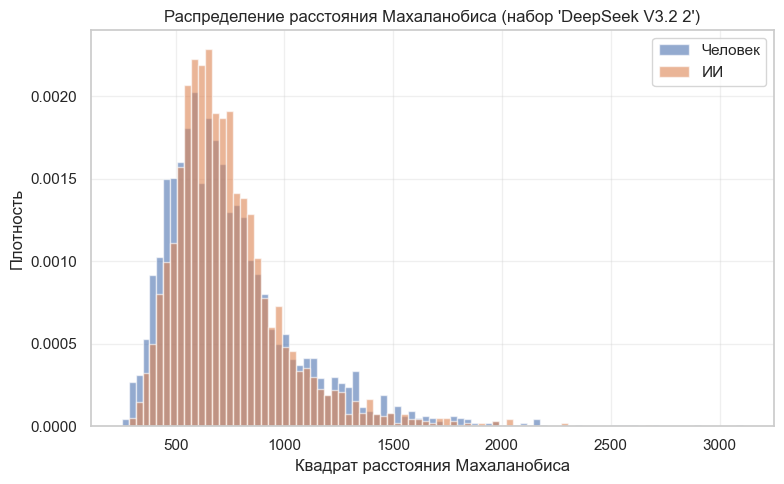

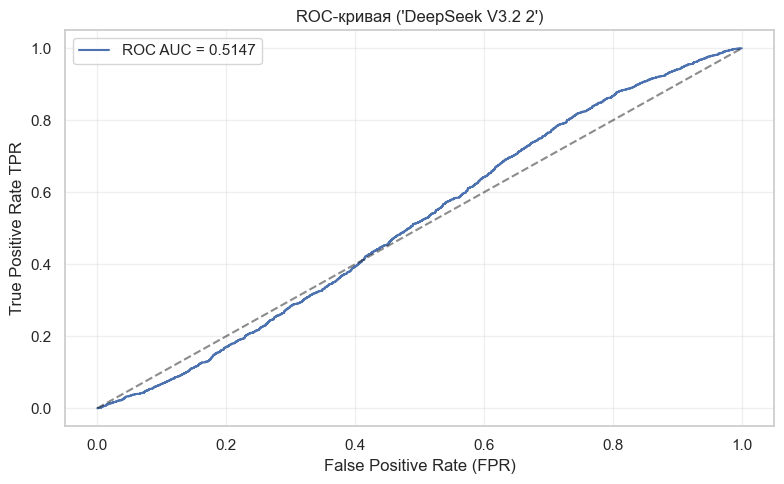

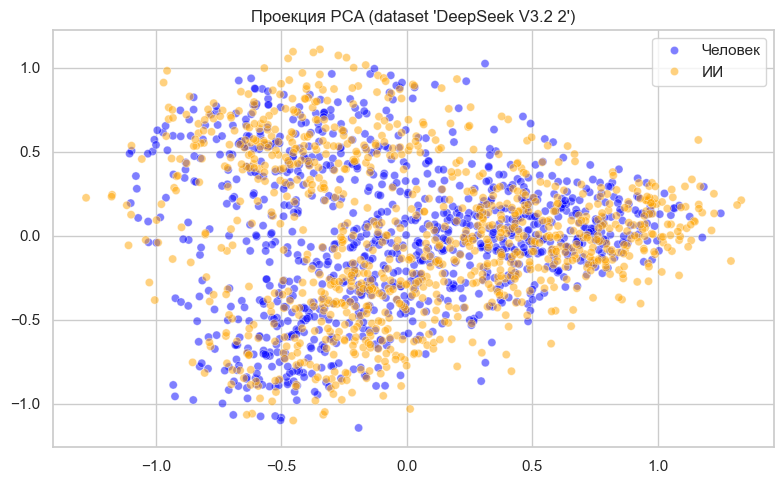


Набор: DeepSeek V3.2 3
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     749.4403
Стд. отклонение    |                     310.7132
Асимметрия         |                       1.8279
Эксцесс            |                       5.8033
95% квантиль       |                    1330.8246
99% квантиль       |                    1807.8526

Статистики расстояния Махаланобиса (ии)
Среднее            |                     739.9762
Стд. отклонение    |                     263.8619
Асимметрия         |                       1.8669
Эксцесс            |                       6.0535
95% квантиль       |                    1224.6124
99% квантиль       |                    1706.5927

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2999
ROC-AUC                            : 0.5100


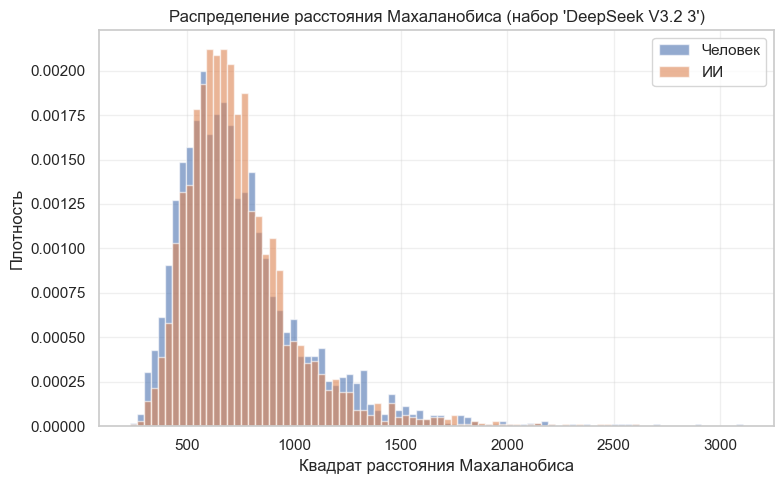

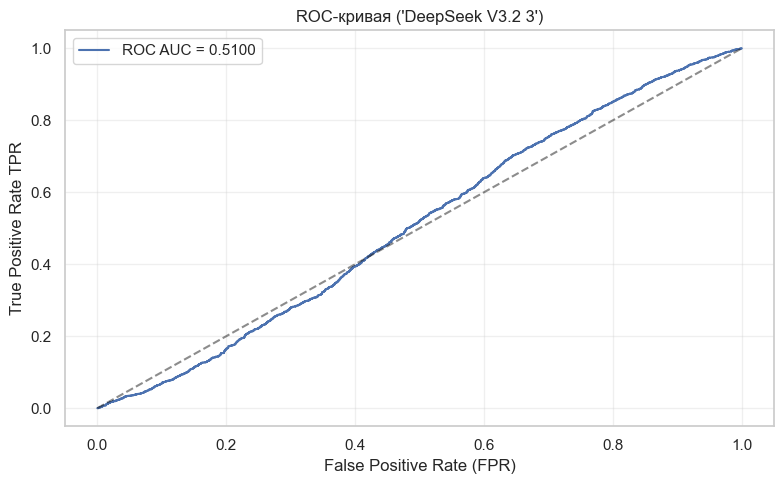

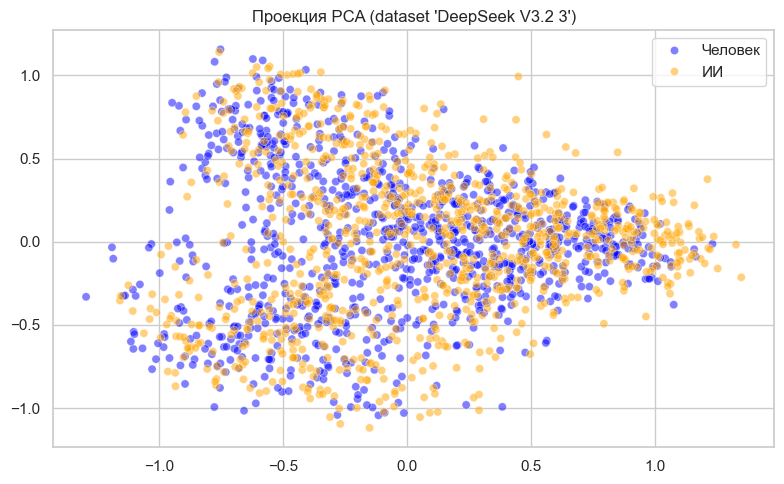


Набор: DeepSeek V3.2 4
----------------------------------------


100%|█████████████████████████████████████████| 188/188 [01:22<00:00,  2.27it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     749.7953
Стд. отклонение    |                     311.2693
Асимметрия         |                       1.8275
Эксцесс            |                       5.7750
95% квантиль       |                    1331.3513
99% квантиль       |                    1814.7336

Статистики расстояния Махаланобиса (ии)
Среднее            |                     745.9571
Стд. отклонение    |                     263.5389
Асимметрия         |                       2.0303
Эксцесс            |                       7.1728
95% квантиль       |                    1237.1998
99% квантиль       |                    1727.7005

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 3000
ROC-AUC                            : 0.5171


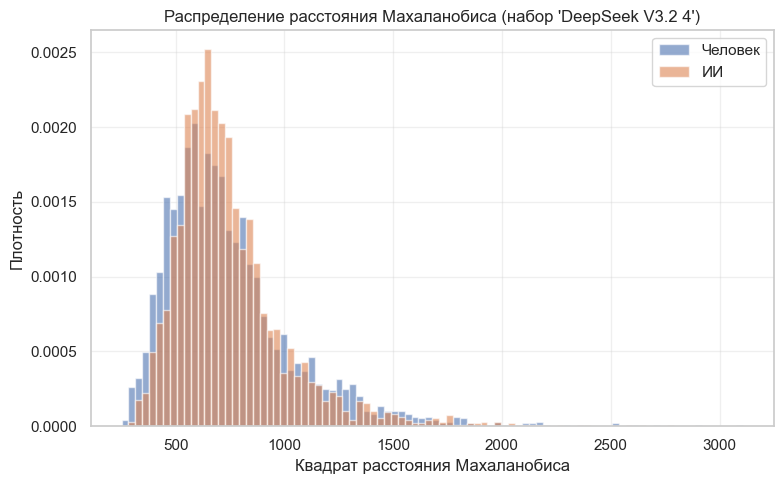

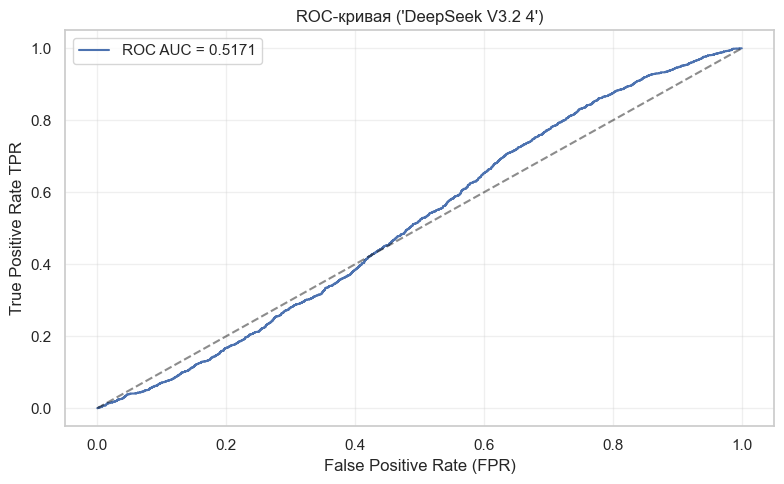

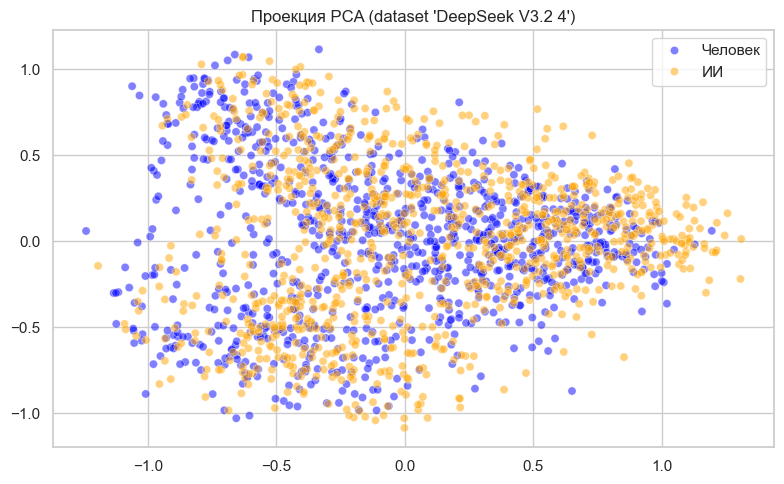


Набор: DeepSeek V3.2 5
----------------------------------------


100%|█████████████████████████████████████████| 157/157 [01:06<00:00,  2.38it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     751.0361
Стд. отклонение    |                     312.9933
Асимметрия         |                       1.8168
Эксцесс            |                       5.7626
95% квантиль       |                    1334.1067
99% квантиль       |                    1828.4945

Статистики расстояния Махаланобиса (ии)
Среднее            |                     748.9992
Стд. отклонение    |                     241.1992
Асимметрия         |                       1.9422
Эксцесс            |                       8.1705
95% квантиль       |                    1186.0974
99% квантиль       |                    1587.8239

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2500
ROC-AUC                            : 0.5325


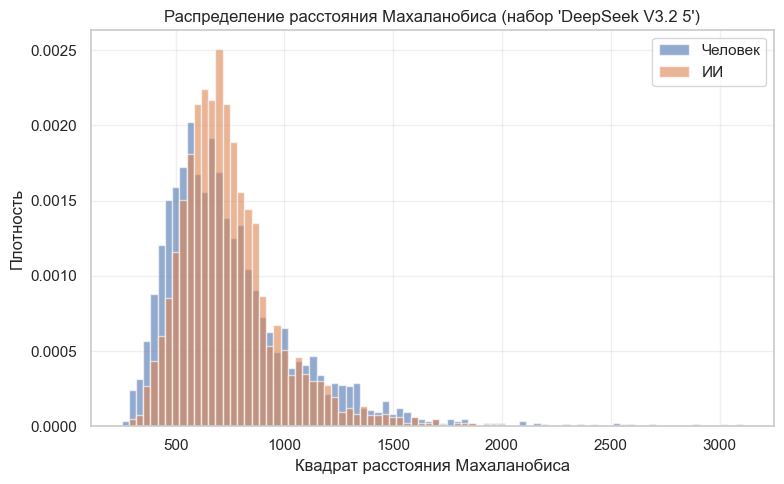

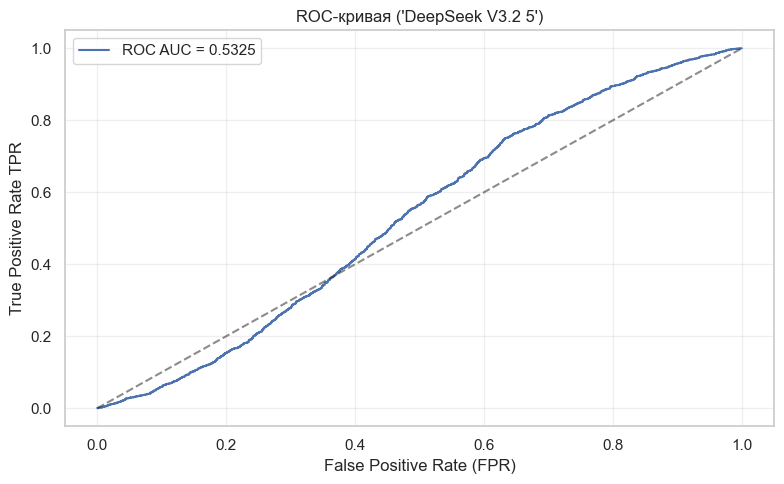

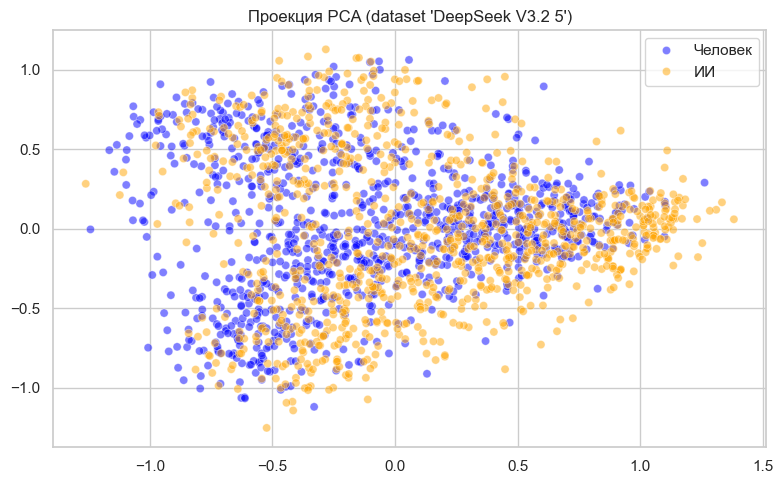


Набор: ChatGPT 1
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:52<00:00,  2.37it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     750.6150
Стд. отклонение    |                     315.3587
Асимметрия         |                       1.9001
Эксцесс            |                       6.4185
95% квантиль       |                    1339.0335
99% квантиль       |                    1828.5421

Статистики расстояния Махаланобиса (ии)
Среднее            |                     769.4208
Стд. отклонение    |                     274.8017
Асимметрия         |                       1.7179
Эксцесс            |                       4.9317
95% квантиль       |                    1290.4863
99% квантиль       |                    1737.5214

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.5442


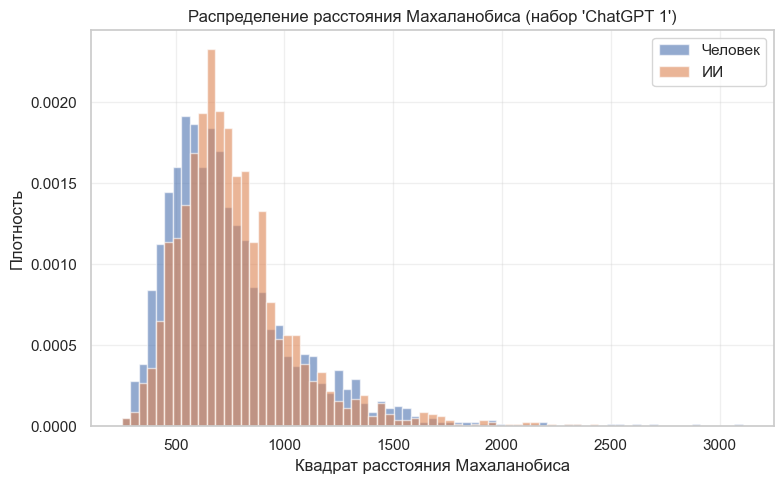

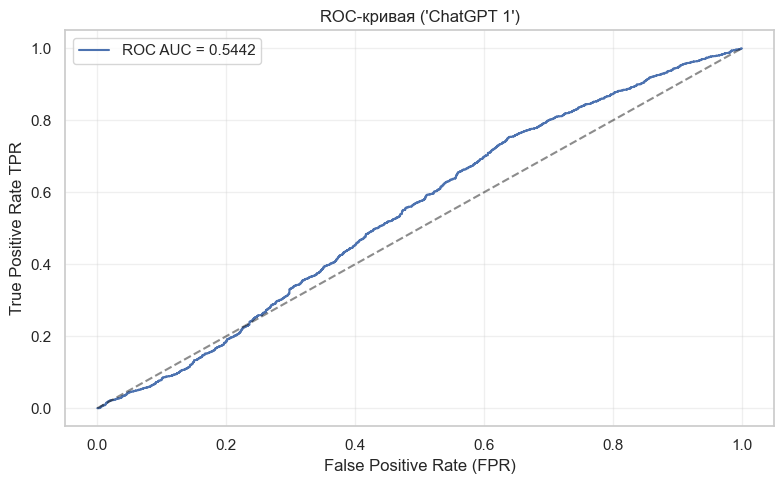

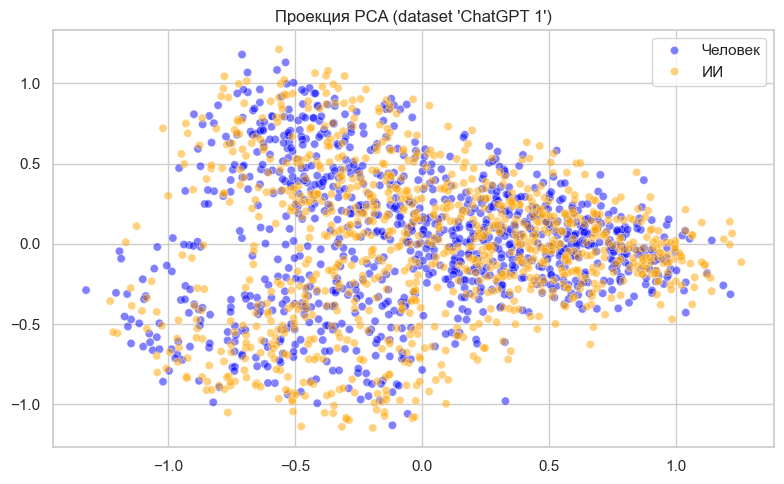


Набор: ChatGPT 2
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:52<00:00,  2.36it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     750.6150
Стд. отклонение    |                     315.3587
Асимметрия         |                       1.9001
Эксцесс            |                       6.4185
95% квантиль       |                    1339.0335
99% квантиль       |                    1828.5421

Статистики расстояния Махаланобиса (ии)
Среднее            |                     771.4620
Стд. отклонение    |                     266.8320
Асимметрия         |                       1.5119
Эксцесс            |                       3.9797
95% квантиль       |                    1282.9642
99% квантиль       |                    1720.2785

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.5490


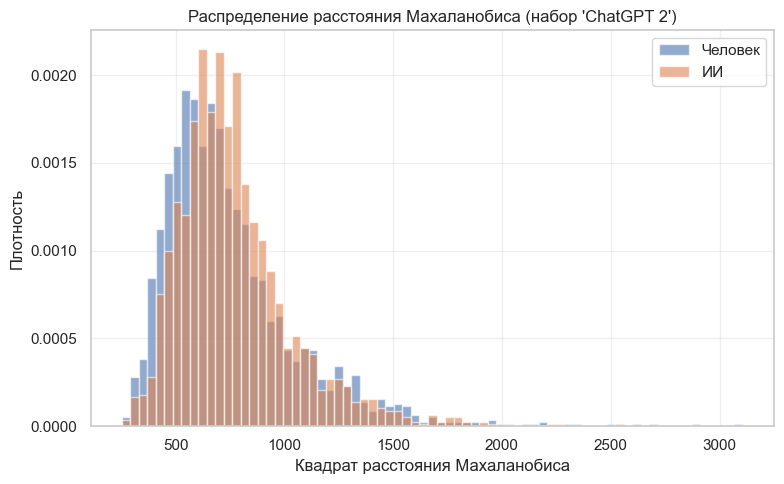

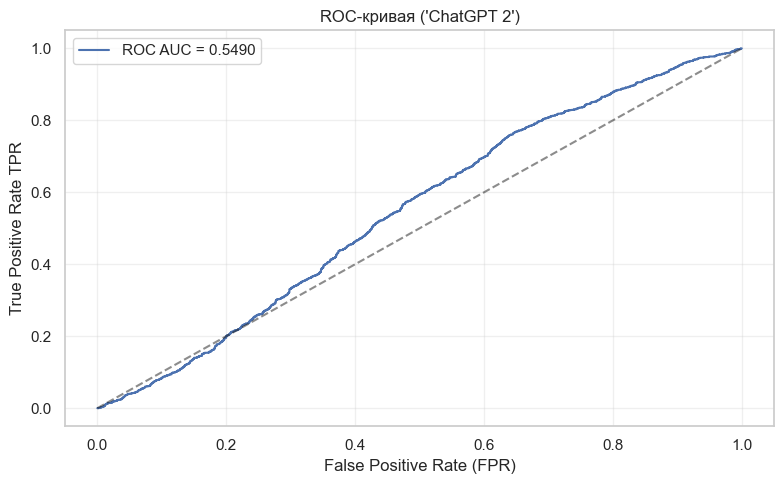

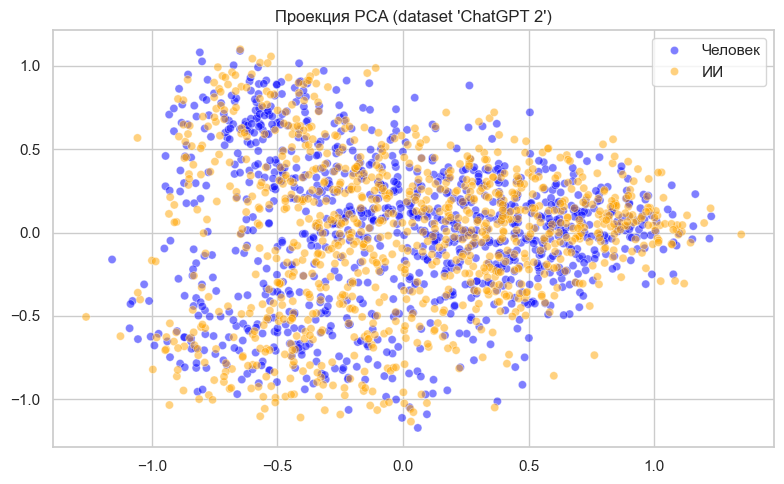


Набор: ChatGPT 3
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:54<00:00,  2.31it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     750.6150
Стд. отклонение    |                     315.3587
Асимметрия         |                       1.9001
Эксцесс            |                       6.4185
95% квантиль       |                    1339.0335
99% квантиль       |                    1828.5421

Статистики расстояния Махаланобиса (ии)
Среднее            |                     772.0319
Стд. отклонение    |                     275.7955
Асимметрия         |                       1.7641
Эксцесс            |                       5.7569
95% квантиль       |                    1293.9546
99% квантиль       |                    1788.6078

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.5464


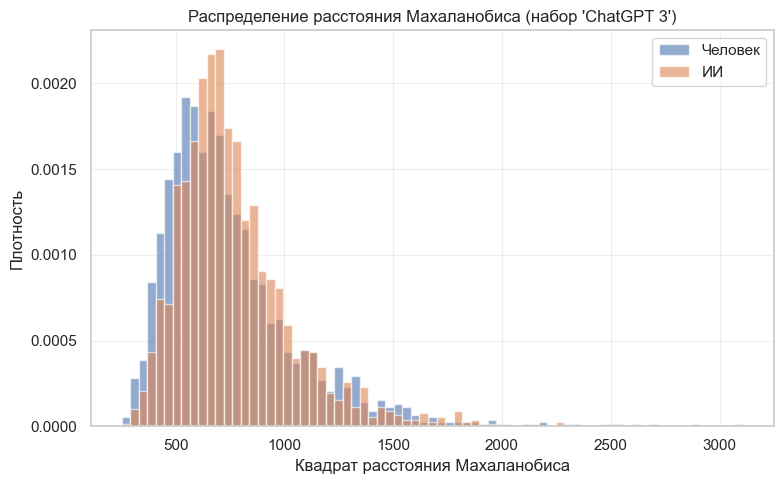

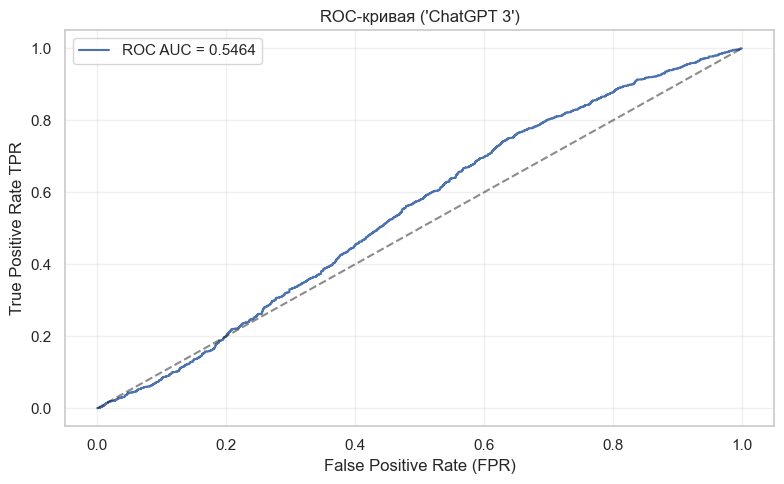

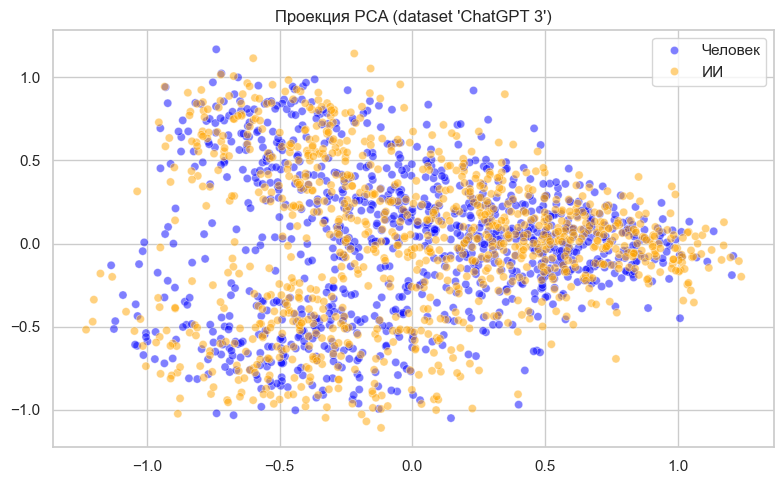


Набор: ChatGPT 4
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:54<00:00,  2.30it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     750.6150
Стд. отклонение    |                     315.3587
Асимметрия         |                       1.9001
Эксцесс            |                       6.4185
95% квантиль       |                    1339.0335
99% квантиль       |                    1828.5421

Статистики расстояния Махаланобиса (ии)
Среднее            |                     797.3854
Стд. отклонение    |                     291.6696
Асимметрия         |                       2.0434
Эксцесс            |                       8.5181
95% квантиль       |                    1356.8976
99% квантиль       |                    1823.2126

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.5708


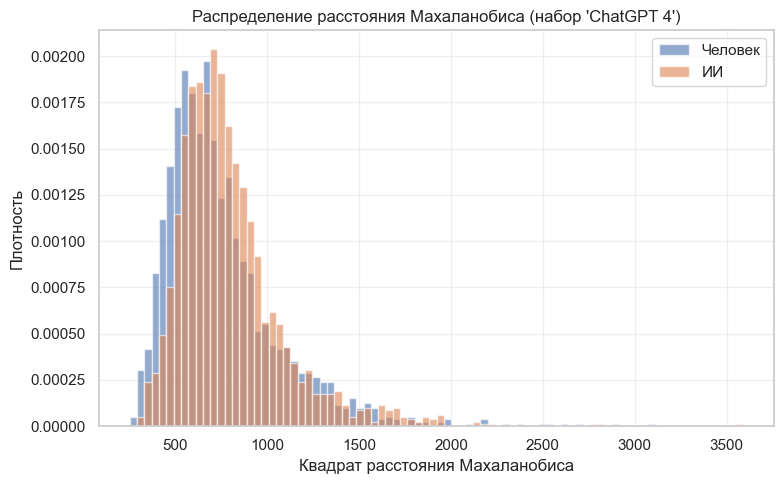

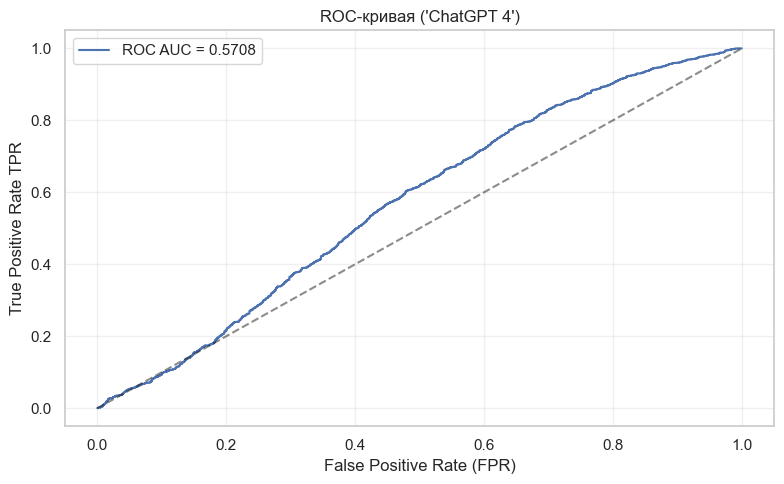

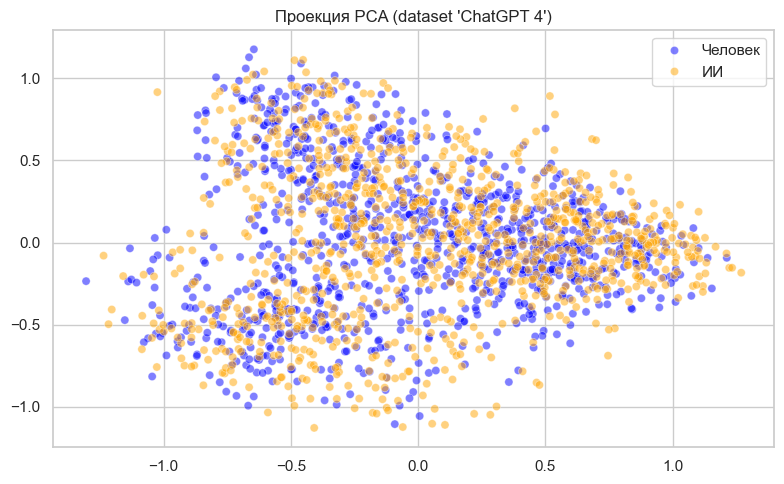


Набор: ChatGPT 5
----------------------------------------


100%|█████████████████████████████████████████| 125/125 [00:53<00:00,  2.34it/s]


Статистики расстояния Махаланобиса (человек)
Среднее            |                     750.6150
Стд. отклонение    |                     315.3587
Асимметрия         |                       1.9001
Эксцесс            |                       6.4185
95% квантиль       |                    1339.0335
99% квантиль       |                    1828.5421

Статистики расстояния Махаланобиса (ии)
Среднее            |                     784.5295
Стд. отклонение    |                     261.9486
Асимметрия         |                       1.8039
Эксцесс            |                       6.9685
95% квантиль       |                    1260.6681
99% квантиль       |                    1715.7756

Количество объектов в 0 классе     : 3000
Количество объектов в 1 классе     : 2000
ROC-AUC                            : 0.5695


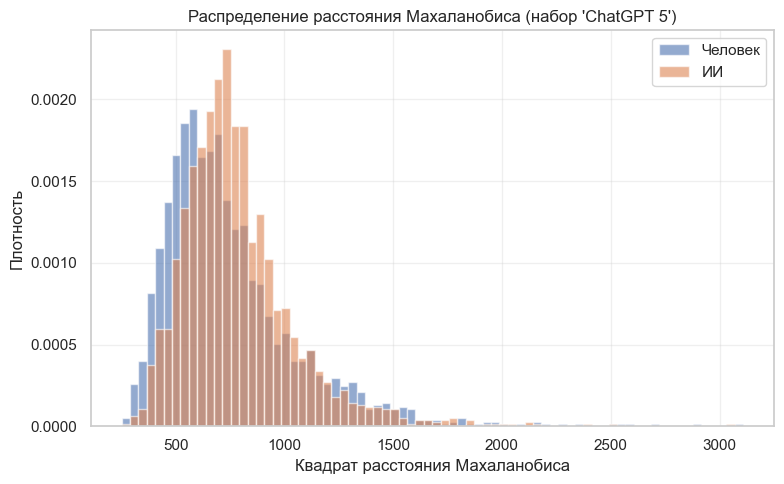

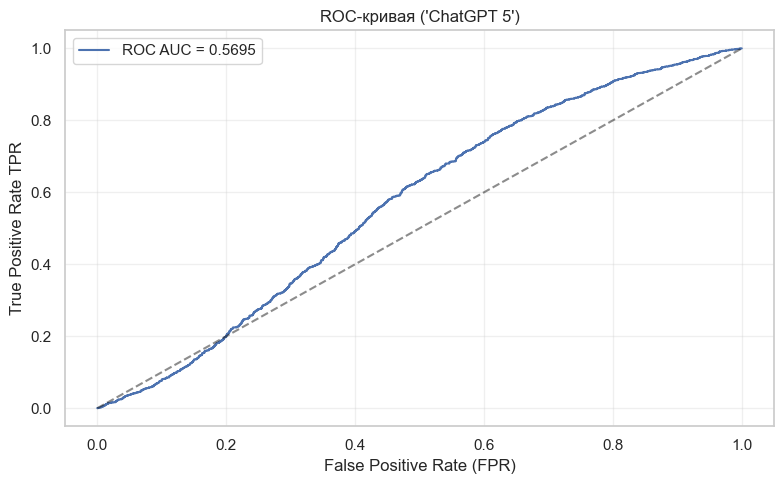

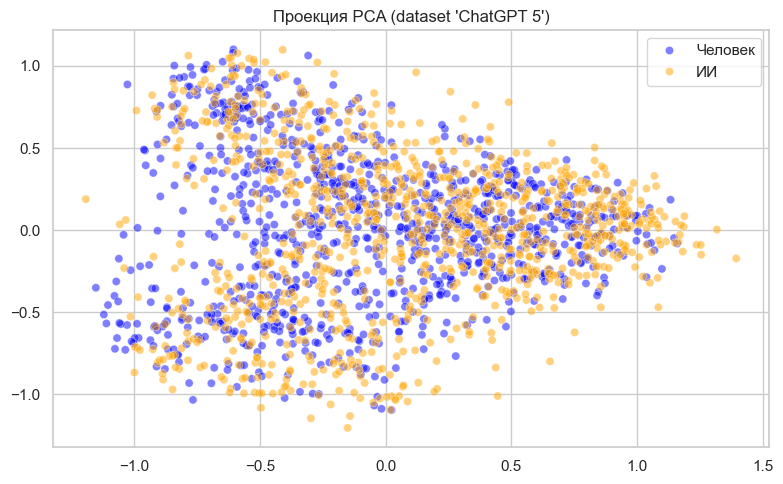

In [7]:
results = []

print_header(f"ENCODER: {ENCODER}")

tokenizer = AutoTokenizer.from_pretrained(ENCODER)
model = AutoModel.from_pretrained(ENCODER)

X_human = get_embeddings(tokenizer, model, human_df["text"])
X_human = X_human.numpy().astype(np.float32)

print_norm_stats(X_human)

X_h_train, X_h_test = train_test_split(
    X_human,
    test_size=0.3,
    random_state=SEED
)

print_kv("Эмбеддинги живых текстов (train)", len(X_h_train))
print_kv("Эмбеддинги живых текстов (test)", len(X_h_test))

cov = LedoitWolf().fit(X_h_train)
scores_h_train = cov.mahalanobis(X_h_train)

covariance_spectrum(cov)

for name, ai_df in ai_datasets.items():
    print(f"\nНабор: {name}")
    print("-" * 40)

    X_ai = get_embeddings(tokenizer, model, ai_df["text"])
    X_ai = X_ai.numpy().astype(np.float32)

    n = min(len(X_h_test), len(X_ai))

    X_test = np.vstack([X_h_test[:n], X_ai[:n]])
    y_test = np.concatenate([
        np.zeros(n, dtype=int),
        np.ones(n, dtype=int)
    ])

    scores = cov.mahalanobis(X_test)
    scores_human = scores[:n]
    scores_ai = scores[n:]

    print_mahalanobis_stats(scores_human, "человек")
    print_mahalanobis_stats(scores_ai, "ии")

    roc_auc = roc_auc_score(y_test, scores)

    print_kv("Количество объектов в 0 классе", len(X_h_test))
    print_kv("Количество объектов в 1 классе", len(X_ai))
    print_kv("ROC-AUC", f"{roc_auc:.4f}")

    plot_mahalanobis_distributions(scores_human, scores_ai, name)
    plot_roc_curve(y_test, scores, roc_auc, name)
    plot_pca_projection(X_h_test, X_ai, name)

    results.append({
        "dataset": name,
        "size": len(X_test),
        "roc_auc": roc_auc,
    })

In [8]:
results_df = pd.DataFrame(results)
print(results_df)

            dataset  size   roc_auc
0      Mistral 7B 1  3000  0.556352
1      Mistral 7B 2  3000  0.585309
2      Mistral 7B 3  3000  0.559241
3      Mistral 7B 4  3000  0.557420
4      Mistral 7B 5  3000  0.581687
5     Llama 3 13B 1  1998  0.578172
6     Llama 3 13B 2  2000  0.608445
7     Llama 3 13B 3  1988  0.581003
8     Llama 3 13B 4  1994  0.563563
9     Llama 3 13B 5  1998  0.559819
10  DeepSeek V3.2 1  6000  0.505913
11  DeepSeek V3.2 2  6000  0.514683
12  DeepSeek V3.2 3  5998  0.509997
13  DeepSeek V3.2 4  6000  0.517133
14  DeepSeek V3.2 5  5000  0.532527
15        ChatGPT 1  4000  0.544174
16        ChatGPT 2  4000  0.549036
17        ChatGPT 3  4000  0.546375
18        ChatGPT 4  4000  0.570799
19        ChatGPT 5  4000  0.569461
